# Lesson 6: pets revisited

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [0]:
bs = 64

In [0]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [0]:
tfms_tr, tfms_val = tfms

In [10]:
tfms_tr

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.4, 0.4)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-20, 20)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.3), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.3, 0.7)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.6, 1.6666666666666667)}, p=1.0, resolved={}, do_r

In [11]:
tfms_val

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
data = get_data(224, bs, 'zeros')

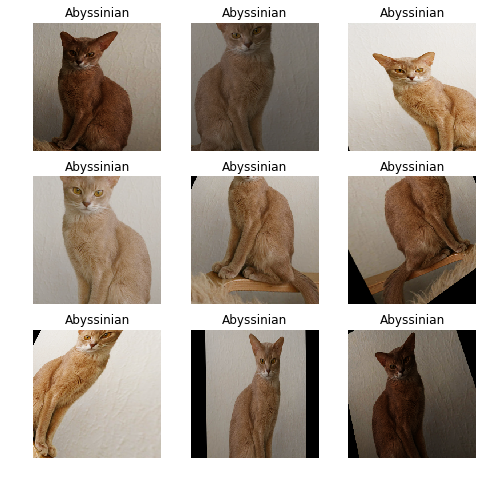

In [21]:
def _plot(i,j,ax):
    x,y = data.train_ds[1]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
data = get_data(224,bs)

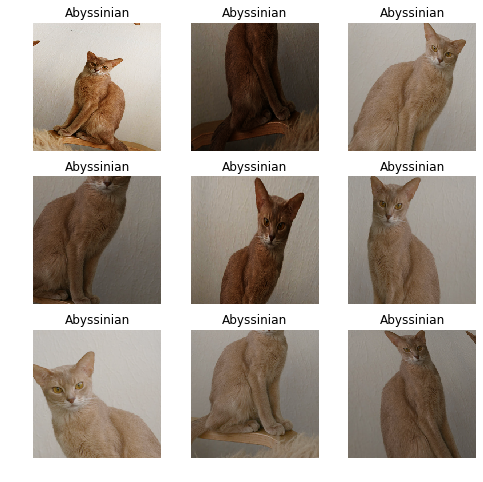

In [23]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [24]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 136795989.86it/s]


In [25]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.529799,1.356285,0.294317,01:35
1,1.526724,0.340866,0.077808,01:31
2,0.927441,0.277098,0.076455,01:30


In [26]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.697789,0.275566,0.061570,01:32
1,0.625547,0.273557,0.060893,01:33


## Convolution kernel

Category Sphynx

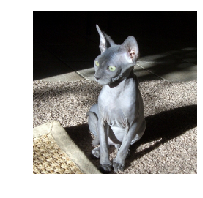

In [45]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [0]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [0]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [40]:
k.shape

torch.Size([1, 3, 3, 3])

In [41]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 224, 224])

In [42]:
t[None].shape

torch.Size([1, 3, 224, 224])

In [0]:
edge = F.conv2d(t[None], k)

In [62]:
edge.shape

torch.Size([1, 1, 222, 222])

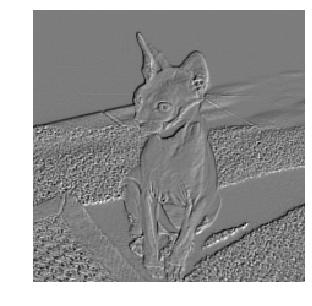

In [44]:
show_image(edge[0], figsize=(5,5));

In [46]:
data.c

37

In [47]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [48]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________

## Heatmap

In [0]:
m = learn.model.eval();

In [50]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
xb.shape

torch.Size([1, 3, 224, 224])

In [0]:
from fastai.callbacks.hooks import *

In [59]:
m[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=37, bias=True)
  (9): BatchNorm1d(37, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
)

In [0]:
def hooked_output():
    with hook_output(m[0]) as hook_a:
      preds = m(xb)
    return hook_a

In [0]:
hook_a= hooked_output()

In [54]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 7, 7])

In [55]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

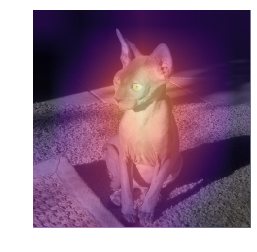

In [57]:
show_heatmap(avg_acts)